# Creating the model

In [38]:
import pandas as pd
import numpy as np
import ml_utils as mlu
import ml_utils_classification as uc
import matplotlib.pyplot as plt
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

In [39]:
symbol = 'AAPL'
aapl = yf.Ticker(symbol)

In [42]:
data = aapl.history(start="2014-05-01", end="2025-05-12", actions=False)

In [ ]:
data.index = pd.to_datetime(data.index)

<Axes: xlabel='Date'>

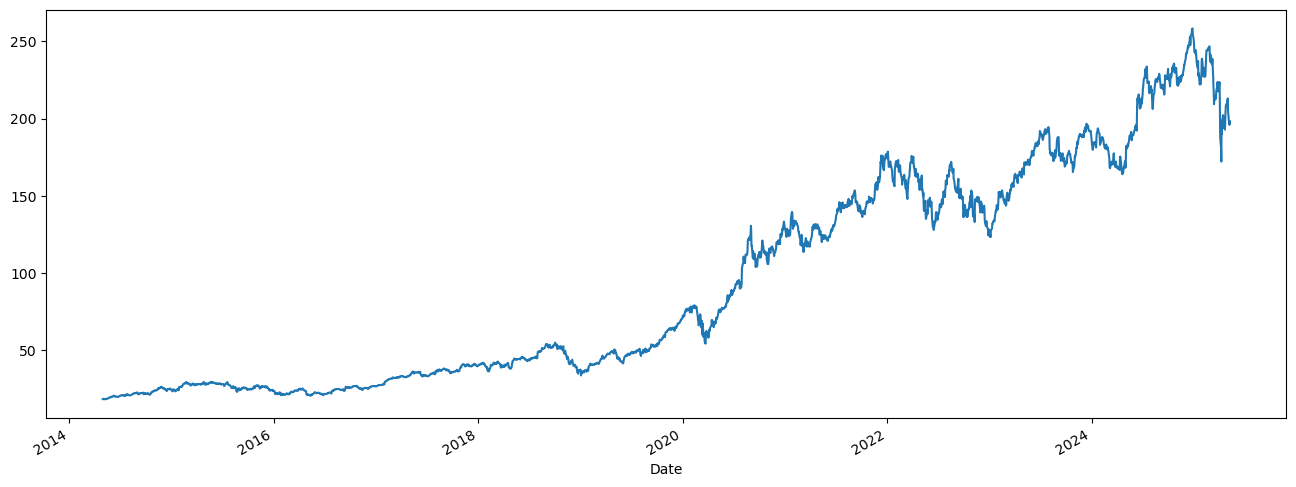

In [47]:
data['Close'].plot(figsize=(16,6))

In [48]:
data

,Open,High,Low,Close,Volume
Date,,,,,
2014-05-01 00:00:00-04:00,18.511154,18.598708,18.334799,18.494896,244048000
2014-05-02 00:00:00-04:00,18.521790,18.579951,18.439552,18.529293,191514400
2014-05-05 00:00:00-04:00,18.452993,18.792573,18.448615,18.791321,287067200
2014-05-06 00:00:00-04:00,18.817587,18.899199,18.586512,18.586512,374564400
2014-05-07 00:00:00-04:00,18.612778,18.676567,18.377636,18.521473,282864400
...,...,...,...,...,...
2025-05-05 00:00:00-04:00,202.834025,203.832716,197.950430,198.629532,69018500
2025-05-06 00:00:00-04:00,197.950420,200.387212,196.761976,198.250015,51216500
2025-05-07 00:00:00-04:00,198.909155,199.178806,192.996910,195.992981,68536700


In [49]:
data['delta'] = data['Close'].diff()

In [51]:
data['direction'] = (data['delta'] > 0).astype(int)

In [54]:
data = mlu.calc_all_default(data)

In [56]:
def direction_momentum(df, horizons=[5, 10, 20, 60]):
    new_df = df.copy()
    for horizon in horizons:
        name = f"direction_mom_{horizon}"
        new_df[name] = new_df['direction'].rolling(horizon).sum() - (horizon/2)
    return new_df

In [57]:
data = direction_momentum(data)

In [59]:
data.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'delta', 'direction',
       'RSI_14', 'SMA_5', 'SMA_10', 'SMA_20', 'SMA_50', 'SMA_100', 'EMA_20',
       'EMA_50', 'EMA_100', 'MACD', 'MACD_Signal', 'BBU_20_2.0', 'BBL_20_2.0',
       'momentum_10', 'ATR_14', 'direction_mom_5', 'direction_mom_10',
       'direction_mom_20', 'direction_mom_60'],
      dtype='object')

In [58]:
data.tail(10)

,Open,High,Low,Close,Volume,delta,direction,RSI_14,SMA_5,SMA_10,...,MACD,MACD_Signal,BBU_20_2.0,BBL_20_2.0,momentum_10,ATR_14,direction_mom_5,direction_mom_10,direction_mom_20,direction_mom_60
Date,,,,,,,,,,,,,,,,,,,,,
2025-04-28 00:00:00-04:00,209.724976,211.223011,207.188309,209.864792,38743100,0.858871,1,52.527699,206.155661,201.855299,...,-2.949127,-5.672050,226.546282,175.254823,11.974304,8.874678,2.5,2.0,2.0,1.0
2025-04-29 00:00:00-04:00,208.416691,211.962045,208.097103,210.933395,36827600,1.068604,1,53.270628,208.446655,202.723161,...,-2.112848,-4.960210,224.623790,176.086745,8.678619,8.516840,2.5,2.0,2.0,2.0
2025-04-30 00:00:00-04:00,209.025904,213.300298,206.399343,212.221710,52286500,1.288315,1,54.201204,210.024585,203.757805,...,-1.330793,-4.234326,222.500788,177.142147,10.346436,8.401420,2.5,3.0,2.0,3.0
2025-05-01 00:00:00-04:00,208.806182,214.279000,208.626409,213.040634,57365700,0.818924,1,54.817149,211.013290,205.660310,...,-0.637579,-3.514977,220.153511,178.433809,19.025055,8.205075,2.5,4.0,2.0,3.0
2025-05-02 00:00:00-04:00,205.820091,206.718922,201.895245,205.081070,101010600,-7.959564,0,48.052654,210.228320,206.496214,...,-0.722148,-2.956411,220.357423,178.445614,8.359039,8.415097,1.5,3.0,2.0,3.0
2025-05-05 00:00:00-04:00,202.834025,203.832716,197.950430,198.629532,69018500,-6.451538,0,43.379966,207.981268,207.068465,...,-1.294829,-2.624095,220.243143,179.609517,5.722504,8.323350,0.5,3.0,2.0,2.0
2025-05-06 00:00:00-04:00,197.950420,200.387212,196.761976,198.250015,51216500,-0.379517,0,43.114369,205.444592,206.945624,...,-1.759029,-2.451082,219.229483,182.325942,-1.228409,7.987771,-0.5,2.0,2.0,2.0
2025-05-07 00:00:00-04:00,198.909155,199.178806,192.996910,195.992981,68536700,-2.257034,0,41.487532,202.198846,206.111716,...,-2.282722,-2.417410,215.233370,188.701933,-8.339081,7.858780,-1.5,1.0,2.0,1.0
2025-05-08 00:00:00-04:00,197.461064,199.788014,194.425036,197.231369,50478900,1.238388,1,42.763668,199.036993,205.025142,...,-2.568219,-2.447572,215.247589,188.551893,-10.865738,7.680508,-1.5,1.0,2.0,1.0
